In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from sklearn.utils import class_weight
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['NORMAL','PNEUMONIA']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [5]:
# Setup directory paths to train and test images
train_dir = 'chest_xray_dataset_1/train'
val_dir = 'chest_xray_dataset_1/val'
test_dir= 'chest_xray_dataset_1/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    val_dir: str,
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  val_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, val_dataloader, class_names, train_data, test_data 

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained,val_dataloader_pretrained, class_names, train_data, test_data = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     val_dir=val_dir,                              
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [9]:
train_labels = train_data.targets
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
if torch.cuda.is_available():
    class_weights_tensor = class_weights_tensor.cuda()

In [10]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2558 | train_acc: 0.8938 | test_loss: 0.1346 | test_acc: 0.9509
Epoch: 2 | train_loss: 0.1751 | train_acc: 0.9313 | test_loss: 0.1153 | test_acc: 0.9609
Epoch: 3 | train_loss: 0.1561 | train_acc: 0.9400 | test_loss: 0.1033 | test_acc: 0.9598
Epoch: 4 | train_loss: 0.1437 | train_acc: 0.9437 | test_loss: 0.1071 | test_acc: 0.9587
Epoch: 5 | train_loss: 0.1552 | train_acc: 0.9438 | test_loss: 0.1055 | test_acc: 0.9598
Epoch: 6 | train_loss: 0.1311 | train_acc: 0.9467 | test_loss: 0.1117 | test_acc: 0.9531
Epoch: 7 | train_loss: 0.1229 | train_acc: 0.9533 | test_loss: 0.1353 | test_acc: 0.9453
Epoch: 8 | train_loss: 0.1199 | train_acc: 0.9535 | test_loss: 0.0990 | test_acc: 0.9576
Epoch: 9 | train_loss: 0.1188 | train_acc: 0.9537 | test_loss: 0.1401 | test_acc: 0.9453
Epoch: 10 | train_loss: 0.1129 | train_acc: 0.9573 | test_loss: 0.0938 | test_acc: 0.9643
Epoch: 11 | train_loss: 0.1120 | train_acc: 0.9580 | test_loss: 0.1046 | test_acc: 0.9598
Epoch: 12 | train_l

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


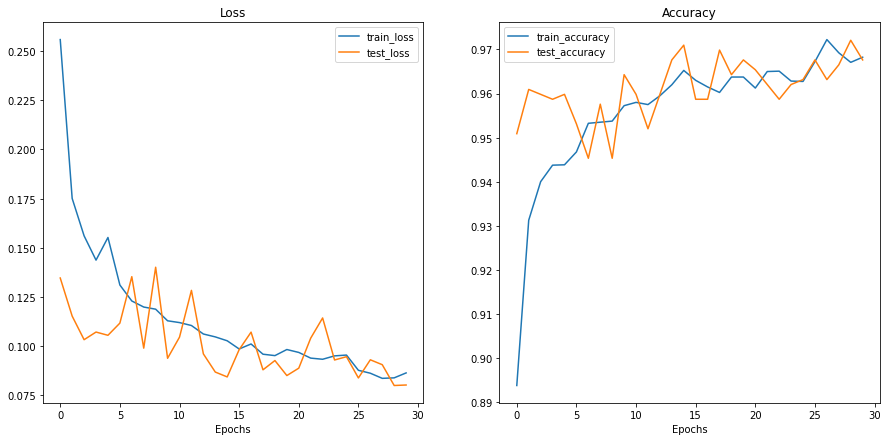

In [11]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

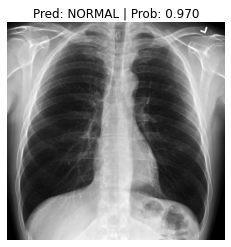

In [12]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "health.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

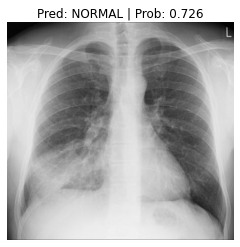

In [13]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "pneumonia_rgb.jpeg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

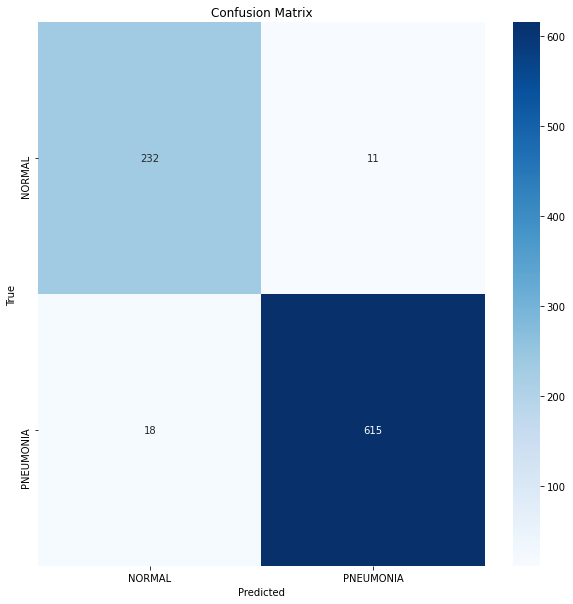

In [14]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(true_labels)

# Compute predictions and true labels
preds, true = get_predictions(pretrained_vit, test_dataloader_pretrained, device)

# Compute the confusion matrix
cm = confusion_matrix(true, preds)
classes = class_names  # Your class names

# Plotting
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix
from math import sqrt

# Compute confusion matrix
cm = confusion_matrix(true, preds)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + 0.5 * (FP + FN))

# Matthews correlation coefficient (MCC)
mcc_numerator = TN * TP - FN * FP
mcc_denominator = sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
mcc_score = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

# Cohen's Kappa score
kappa_numerator = 2 * (TP * TN - FN * FP)
kappa_denominator = (TP + FP) * (FP + TN) + (TP + FN) * (FN + TN)
kappa_score = kappa_numerator / kappa_denominator if kappa_denominator != 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"MCC Score: {mcc_score:.4f}")
print(f"Kappa Score: {kappa_score:.4f}")


Accuracy: 0.9669
Precision: 0.9824
Recall: 0.9716
F1 Score: 0.9770
MCC Score: 0.9183
Kappa Score: 0.9181


In [16]:
model_save_path = "vit_model_test.pth"
torch.save(pretrained_vit.state_dict(), model_save_path)


In [17]:
torch.load(model_save_path)

OrderedDict([('class_token',
              tensor([[[-1.1816e-03,  2.7023e-03,  2.5492e-03, -1.0183e-03, -6.8836e-04,
                        -7.0989e-03, -1.0262e-03, -5.0719e-04, -3.4578e-04,  7.2080e-04,
                        -1.2402e-03,  7.5692e-03, -7.7170e-04, -4.8869e-04, -3.9637e-03,
                        -1.4612e-03, -1.1996e-03, -6.3172e-04, -1.0178e-03, -6.6078e-04,
                        -1.0705e-03, -6.4979e-03, -7.7540e-04, -6.0426e-04, -7.3446e-04,
                        -3.1418e-03, -7.1227e-03, -1.0940e-03, -2.3099e-03, -7.0811e-04,
                        -8.9314e-04, -5.3678e-04,  7.4808e-03, -3.7627e-04, -1.5883e-03,
                        -7.2012e-04, -2.4297e-04, -6.3393e-04, -7.0300e-04, -6.7053e-04,
                         4.7179e-03, -7.9351e-04,  2.6560e-03, -1.0116e-03,  2.9899e-03,
                        -8.4867e-04, -5.3730e-03, -5.1106e-04,  5.5209e-03, -7.5487e-04,
                        -4.7614e-04, -2.3371e-03, -1.0001e-02, -5.9229e-04,  3.36

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_attention_map(model, img, transform, get_mask=False):
    # Apply transformations and add batch dimension
    x = transform(img).unsqueeze(0)


    # Move the input tensor to the specified device (GPU or CPU)
    x = x.to(device)

    # Ensure the model is on the same device
    model = model.to(device)

    # Forward pass through the model
    print(model(x))
    logits, att_mat = model(x)


    # Process attention matrices
    att_mat = torch.stack(att_mat).squeeze(1)
    att_mat = torch.mean(att_mat, dim=1)
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursive multiplication for joint attention
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Convert to numpy for visualization
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

    # Resize mask and apply to the image
    if get_mask:
        return cv2.resize(mask / mask.max(), (img.size[1], img.size[0]))
    else:
        mask = cv2.resize(mask / mask.max(), (img.size[1], img.size[0]))[..., np.newaxis]
        result = (mask * np.asarray(img)).astype("uint8")
        return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)


In [19]:
# from PIL import Image

# # Load and preprocess an image
# original_img = Image.open('pneumonia_rgb.jpeg')
# transformed_img = original_img  # Use the same transform as for your dataset

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # Get the attention map
# att_map = get_attention_map(pretrained_vit, original_img, pretrained_vit_transforms, get_mask=False)

# # Plot the attention map
# plot_attention_map(original_img, att_map)
